In [1]:
#!/usr/bin/env python3
import numpy as np
import time
import JaxPeriodDrwFit
import pandas as pd
# import dill as pickle
import cloudpickle as pickle
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

from tape.ensemble import Ensemble
from tape.utils import ColumnMapper



# Init analysis 

In [2]:
# generated in create_data script, to avoid epyc failure
t_multi = np.load('/astro/users/ncaplar/data/t_multi.npy')
y_multi = np.load('/astro/users/ncaplar/data/y_multi.npy')
yerr_multi = np.load('/astro/users/ncaplar/data/yerr_multi.npy')

In [5]:

id, t, y, yerr, filter = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

for i in range(100):
    # data = data_all[()].get(i)

    # get time for a single lightcurve
    t_true = t_multi[i]
    # sample 100 points from 200
    downsample_int = np.sort(np.random.choice(np.arange(len(t_true)), 100))
    # extract 100 times from 200
    t_single = t_true[downsample_int]

    id = np.append(id, np.full(len(downsample_int), i))
    filter_single = np.full(len(t_single), 'r')
    t = np.append(t, t_single)
    filter = np.append(filter, filter_single)

    # create custom errors
    y_err_single = np.full(len(t_single), 0.001)
    yerr = np.append(yerr, np.full(len(t_single), 0.001))

    # extract measurements; 100 from each lightcurve
    # y_pre = data['y_tot'][downsample_int]
    y_pre = y_multi[i][downsample_int]

    # create noise and add to lightcurves
    noise = np.random.normal(0, y_err_single)
    y = np.append(y, y_pre + noise)

# columns assigned manually
manual_colmap = ColumnMapper().assign(
    id_col="id", time_col="t", flux_col="y", err_col="yerr", band_col="filter"
)

# ens = Ensemble(silence_logs='error')
ens = Ensemble()
ens.from_source_dict({'id': id, "t": t, 'y': y, 'yerr': yerr, 'filter': filter},
                        column_mapper=manual_colmap)
single_lc = ens.compute("source")[id == 0]
# comment out line below if trying to run ensamble.batch
# ens.client.close()
##########



/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33111 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:45433
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:33111/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36501'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40385'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39963'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43357'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34079'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41804'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35388'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42303'


In [6]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()

In [7]:
ens.head("object", 5)

filter,nobs_r,nobs_total
id,,
0.0,100,100
1.0,100,100
2.0,100,100
3.0,100,100
4.0,100,100


In [8]:
ens.head("source", 5)

,t,y,yerr,filter
id,,,,
0.0,104.035404,-0.178309,0.001,r
0.0,110.606061,-0.114827,0.001,r
0.0,136.523652,-0.119349,0.001,r
0.0,148.569857,0.029500,0.001,r
0.0,150.760076,0.053097,0.001,r


In [9]:
# 20.6 second
res = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 't', 'y', 'yerr',
                 compute=True, meta=None, n_init=100)
print(res)

id
0.0     [-129.8543171310671, 2.2952704672830704, -0.77...
1.0     [-125.06774239793788, 2.2454832550376214, -0.6...
2.0     [-129.19153581396438, 2.0109551037342817, -0.8...
3.0     [-113.93138087222452, 1.664258493219286, -0.83...
4.0     [-124.25437066957599, 2.3919998011020134, -0.6...
                              ...                        
95.0    [-123.59434269083566, 2.2617468727321612, -0.7...
96.0    [-134.95465378350644, 1.7851771511631847, -0.8...
97.0    [-126.45339674303835, 2.0249693391299366, -0.7...
98.0    [-129.96935212915713, 1.5254637793727104, -0.9...
99.0    [-106.14477313607473, 2.0904558534035984, -0.6...
Name: id, Length: 100, dtype: object


In [10]:
ens.client.close()

INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:36501'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:40385'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:39963'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:43357'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:34079'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:41804'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0

# Redback - exploring degrading lightcurve to ZTF cadence

In [11]:
t = single_lc['t'].values
y = single_lc['y'].values
yerr = single_lc['yerr'].values

# This block shows that the code works on a single lightcurve
# And it is faster second time
t1 = time.time()
test_single_lc_res = JaxPeriodDrwFit_instance.optimize_map(t, y, yerr, n_init=100)
t2 = time.time()
print(f'Execution time for single lc is {t2 - t1} sec')
print('Best result is:' + str(test_single_lc_res))
t1 = time.time()
test_single_lc_res = JaxPeriodDrwFit_instance.optimize_map(t, y, yerr, n_init=100)
t2 = time.time()
print(f'Execution time for second run with single lc is {t2 - t1} sec')
print('Best result is:' + str(test_single_lc_res))

Execution time for single lc is 4.026710748672485 sec
Best result is:[-129.85431713    2.29527047   -0.77088343    1.42985345   -1.39499854]
Execution time for second run with single lc is 0.1607820987701416 sec
Best result is:[-129.85431713    2.29527047   -0.77088343    1.42985345   -1.39499854]


In [12]:
datadir = '/astro/users/ncaplar/github/redback/redback/tables'
pointings_database_name = 'ztf.tar.gz'

In [13]:
pointings_database = pd.read_csv(datadir + "/" + pointings_database_name, compression='gzip')

In [14]:
# 58288.17 = June-19-2018
# 59822.52 = August-31-2022
np.sort(pointings_database['expMJD'].values)

array([58288.17 , 58288.176, 58288.18 , ..., 59822.51 , 59822.516,
       59822.52 ])

In [15]:
pointings_database['_ra']

0         3.822735
1         4.436831
2         3.560472
3         3.355396
4         3.520526
            ...   
106643    1.984300
106644    2.114880
106645    2.039341
106646    2.114880
106647    0.923487
Name: _ra, Length: 106648, dtype: float64

In [26]:
survey_fov_sqdeg = 36
survey_fov_sqrad = survey_fov_sqdeg*(np.pi/180.0)**2
survey_radius = np.sqrt(survey_fov_sqrad/np.pi)
print('survey_radius:' + str(survey_radius))

def find_sky_overlaps(pointings_databasem, parameters):
    """
    Find the sky indices of the pointings database that overlap with the transient.
    """
    pointings_sky_pos = np.column_stack((pointings_database['_ra'].values, pointings_database['_dec'].values))
    transient_sky_pos = np.column_stack((parameters['ra'].values, parameters['dec'].values))

    transient_sky_pos_3D = np.vstack([np.cos(transient_sky_pos[:,0]) * np.cos(transient_sky_pos[:,1]),
                                        np.sin(transient_sky_pos[:,0]) * np.cos(transient_sky_pos[:,1]),
                                        np.sin(transient_sky_pos[:,1])]).T
    pointings_sky_pos_3D = np.vstack([np.cos(pointings_sky_pos[:, 0]) * np.cos(pointings_sky_pos[:,1]),
                                        np.sin(pointings_sky_pos[:,0]) * np.cos(pointings_sky_pos[:,1]),
                                        np.sin(pointings_sky_pos[:,1])]).T
    # law of cosines to compute 3D distance
    max_3D_dist = np.sqrt(2. - 2. * np.cos(survey_radius))
    survey_tree = KDTree(pointings_sky_pos_3D)
    overlap_indices = survey_tree.query_ball_point(x=transient_sky_pos_3D, r=max_3D_dist)

    return overlap_indices, transient_sky_pos_3D, pointings_sky_pos_3D

survey_radius:0.05908179503018386


In [27]:
np.sqrt(36/np.pi)/(np.pi*180)

0.005986237404172219

In [28]:
survey_fov_sqrad
survey_radius

0.05908179503018386

In [40]:
parameters = pd.DataFrame(np.array([[0, 1, 2], [0.2813573, 1, 2], [-0.0978646, 1, 2]]).T,
                   columns=['id', 'ra', 'dec'])

parameters_deg = parameters.copy()

parameters['ra'] = parameters_deg['ra'] * np.pi/180
parameters['dec'] = parameters_deg['dec'] * np.pi/180

In [41]:
parameters_deg

,id,ra,dec
0,0.0,0.281357,-0.097865
1,1.0,1.000000,1.000000
2,2.0,2.000000,2.000000


In [57]:
time_space_overlap, transient_sky_pos_3D, pointings_sky_pos_3D = find_sky_overlaps(pointings_database, parameters)

In [67]:
time_space_overlap

array([list([1197, 6218, 6747, 26673, 53966, 59013, 63142, 72220, 89371, 90141, 104257]),
       list([53966, 89371]),
       list([6440, 8696, 28612, 29057, 53966, 84899, 88721, 89371, 89849, 90726])],
      dtype=object)

In [58]:
transient_sky_pos_3D

array([[ 0.99998648,  0.00491058, -0.00170806],
       [ 0.99969541,  0.01744975,  0.01745241],
       [ 0.99878203,  0.03487824,  0.0348995 ]])

In [64]:
transient_sky_pos_3D

array([[ 0.99998648,  0.00491058, -0.00170806],
       [ 0.99969541,  0.01744975,  0.01745241],
       [ 0.99878203,  0.03487824,  0.0348995 ]])

In [66]:
pointings_sky_pos_3D

array([[-0.7744059 , -0.62769611,  0.07932904],
       [-0.2442343 , -0.8637784 ,  0.44072268],
       [-0.32216947, -0.14343914,  0.93575213],
       ...,
       [-0.42711299,  0.84386997,  0.32474292],
       [-0.4646512 ,  0.76802525,  0.44072268],
       [ 0.54983123,  0.72732088, -0.41071884]])

In [55]:
overlapping_database_iter = pointings_database.iloc[time_space_overlap[0]]

In [56]:
overlapping_database_iter

,expMJD,filter,fiveSigmaDepth,_ra,_dec
1197,58302.480,ztfi,20.223915,0.029788,-0.046251
6218,58364.293,ztfg,21.521942,6.251594,-0.046251
6747,58369.380,ztfr,21.425386,0.030956,-0.046251
26673,58697.438,ztfi,20.487064,0.029788,-0.046251
53966,59056.460,ztfr,21.695518,0.060614,0.016581
59013,59116.312,ztfr,21.050300,0.029788,-0.046251
63142,59156.223,ztfg,20.242613,6.250925,-0.046251
72220,59256.098,ztfr,19.394804,0.029788,-0.046251
89371,59483.340,ztfr,20.635460,0.060614,0.016581
90141,59491.316,ztfi,20.690083,0.029788,-0.046251


In [68]:
overlapping_database_iter

,expMJD,filter,fiveSigmaDepth,_ra,_dec
1197,58302.480,ztfi,20.223915,0.029788,-0.046251
6218,58364.293,ztfg,21.521942,6.251594,-0.046251
6747,58369.380,ztfr,21.425386,0.030956,-0.046251
26673,58697.438,ztfi,20.487064,0.029788,-0.046251
53966,59056.460,ztfr,21.695518,0.060614,0.016581
59013,59116.312,ztfr,21.050300,0.029788,-0.046251
63142,59156.223,ztfg,20.242613,6.250925,-0.046251
72220,59256.098,ztfr,19.394804,0.029788,-0.046251
89371,59483.340,ztfr,20.635460,0.060614,0.016581
90141,59491.316,ztfi,20.690083,0.029788,-0.046251


Text(0, 0.5, 'dec')

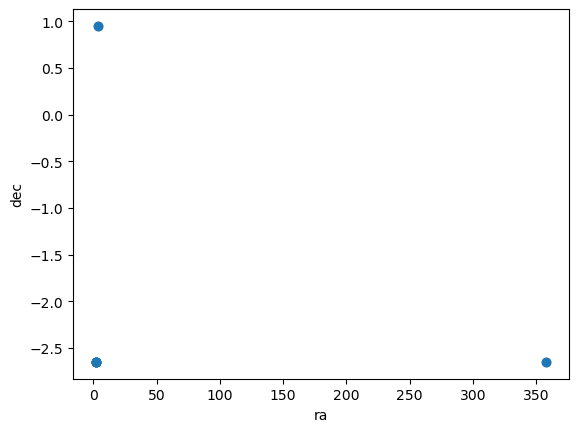

In [51]:
plt.scatter(overlapping_database_iter['_ra']*180/np.pi, overlapping_database_iter['_dec']*180/np.pi)
plt.xlabel('ra')
plt.ylabel('dec')

Text(0, 0.5, 'dec [deg]')

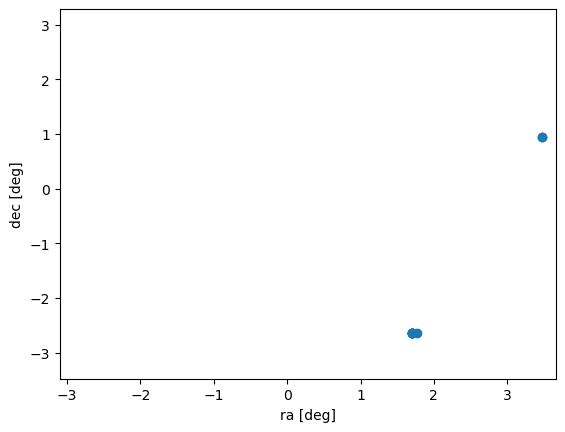

In [78]:
plt.scatter(pointings_database['_ra']*180/np.pi, pointings_database['_dec']*180/np.pi)
plt.xlim(0.2813573 - 3.38, 0.2813573 + 3.38)
plt.ylim(-0.097865 - 3.38, -0.097865 + 3.38)
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')


In [84]:
a = (pointings_database['_ra']*180/np.pi < 3.38) 
b = (pointings_database['_ra']*180/np.pi > - 3.38) 
c = (pointings_database['_dec']*180/np.pi < 3.38) 
d = (pointings_database['_dec']*180/np.pi > - 3.38)

In [90]:
ab = np.logical_and(a, b)
cd = np.logical_and(c, d)
abcd = np.logical_and(ab, cd)
pointings_database[abcd]

,expMJD,filter,fiveSigmaDepth,_ra,_dec
1197,58302.480,ztfi,20.223915,0.029788,-0.046251
6747,58369.380,ztfr,21.425386,0.030956,-0.046251
26673,58697.438,ztfi,20.487064,0.029788,-0.046251
59013,59116.312,ztfr,21.050300,0.029788,-0.046251
72220,59256.098,ztfr,19.394804,0.029788,-0.046251
90141,59491.316,ztfi,20.690083,0.029788,-0.046251
104257,59789.418,ztfg,21.390000,0.029788,-0.046251


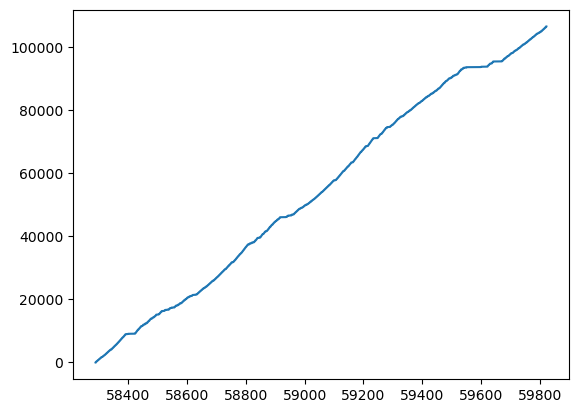

In [74]:
plt.plot(pointings_database['expMJD'],np.arange(len(pointings_database)))

In [89]:
survey_fov_sqdeg = 41253
survey_fov_sqrad = survey_fov_sqdeg*(np.pi/180.0)**2
survey_radius = np.sqrt(survey_fov_sqrad/np.pi)

In [100]:
int(np.min(pointings_database['expMJD']))

58288

In [103]:
# 30 sec exposure
exp_count_per_night=[]
for i in range(int(np.min(pointings_database['expMJD'])), int(np.max(pointings_database['expMJD']))):

    ab = np.logical_and(pointings_database['expMJD']>i, pointings_database['expMJD']<(i+1))
    exp_count_per_night.append(len(pointings_database[ab]))
    
exp_count_per_night = np.array(exp_count_per_night)

In [125]:
np.median(exp_count_per_night[exp_count_per_night>0])

92.0

(array([ 28.,  27.,  40.,  40.,  50., 181., 337., 187., 154., 122.]),
 array([  1. ,  14.9,  28.8,  42.7,  56.6,  70.5,  84.4,  98.3, 112.2,
        126.1, 140. ]),
 <BarContainer object of 10 artists>)

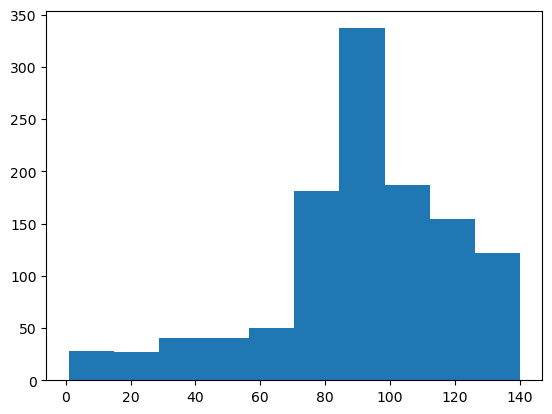

In [106]:
plt.hist(exp_count_per_night[exp_count_per_night>0])

In [109]:
int(np.min(pointings_database['expMJD']))
# Mar - 19 - 2022

58288

In [108]:
int(np.max(pointings_database['expMJD']))
# Aug - 31 - 2022

59822

In [112]:
a = (pointings_database['expMJD'] < 58289) 
b = (pointings_database['expMJD'] > 58288) 
pointings_database[np.logical_and(a,b)]

,expMJD,filter,fiveSigmaDepth,_ra,_dec
0,58288.170,ztfi,19.931356,3.822735,0.079412
1,58288.176,ztfi,20.210491,4.436831,0.456404
2,58288.180,ztfi,20.540510,3.560472,1.210386
3,58288.184,ztfi,20.345324,3.355396,0.582067
4,58288.188,ztfi,20.411247,3.520526,0.330740
...,...,...,...,...,...
76,58288.465,ztfr,19.961952,0.400126,0.267908
77,58288.470,ztfr,20.274796,0.491055,0.959058
78,58288.473,ztfr,20.703732,5.834386,1.084722
79,58288.477,ztfr,20.915184,6.045699,0.519235


In [115]:
(58288.176 - 58288.173)*24*3600

259.1999997384846

In [121]:
np.median(np.diff(pointings_database['expMJD'])*24*3600)

345.600000070408

In [123]:
np.median(np.diff(pointings_database['expMJD']))

0.004000000000814907

# Redback - exploring degrading lightcurve to LSST cadence 

In [126]:
datadir = '/astro/users/ncaplar/github/redback/redback/tables'
pointings_database_name = 'rubin_baseline_v3.0_10yrs.tar.gz'

In [127]:
pointings_database = pd.read_csv(datadir + "/" + pointings_database_name, compression='gzip')

In [128]:
pointings_database

,obsHistID,_ra,_dec,expMJD,filter,fiveSigmaDepth
0,0,5.211615,-0.271831,60218.001806,lssty,22.546480
1,1,5.184243,-0.229415,60218.002260,lssty,22.532127
2,2,5.156032,-0.276708,60218.002715,lssty,22.546281
3,3,6.218399,-0.892994,60218.004914,lsstr,23.128326
4,4,0.002771,-0.927466,60218.005362,lsstr,23.075882
...,...,...,...,...,...,...
2086074,2086074,0.242628,-0.300568,63870.104316,lssty,21.765412
2086075,2086075,0.286405,-0.337880,63870.104764,lssty,21.700841
2086076,2086076,0.237859,-0.352882,63870.105213,lssty,21.743835
2086077,2086077,0.193195,-0.316096,63870.105661,lssty,21.765063


Text(0, 0.5, 'dec')

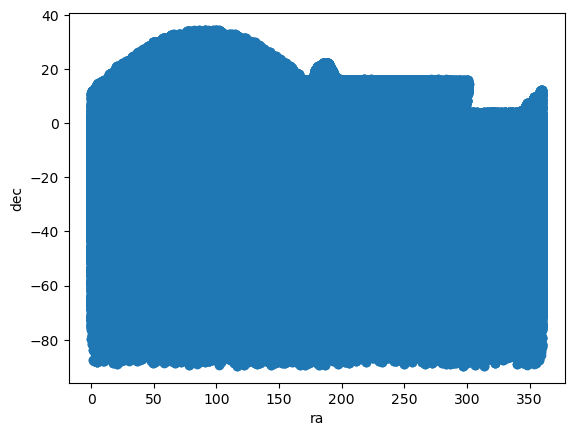

In [129]:
plt.scatter(pointings_database['_ra']*180/np.pi, pointings_database['_dec']*180/np.pi)
plt.xlabel('ra')
plt.ylabel('dec')

In [130]:
survey_fov_sqdeg = 9.6
survey_fov_sqrad = survey_fov_sqdeg*(np.pi/180.0)**2
survey_radius = np.sqrt(survey_fov_sqrad/np.pi)
print('survey_radius:' + str(survey_radius))

survey_radius:0.03050970776212563


In [131]:
parameters = pd.DataFrame(np.array([[0, 1, 2], [0.2813573, 1, 2], [-0.0978646, 1, 2]]).T,
                   columns=['id', 'ra', 'dec'])

parameters_deg = parameters.copy()

parameters['ra'] = parameters_deg['ra'] * np.pi/180
parameters['dec'] = parameters_deg['dec'] * np.pi/180

time_space_overlap, transient_sky_pos_3D, pointings_sky_pos_3D = find_sky_overlaps(pointings_database, parameters)

In [142]:
overlapping_database_iter = pointings_database.iloc[time_space_overlap[0]]
single_filter_single_position = overlapping_database_iter[overlapping_database_iter['filter']=='lsstr']['expMJD']
single_filter_single_position.values


array([60228.01939646, 60229.15751636, 60233.09121907, 60248.13913665,
       60248.1400404 , 60264.06419325, 60285.03369158, 60292.04841646,
       60438.42810582, 60438.43120199, 60442.42964177, 60442.43273505,
       60492.399031  , 60502.37472491, 60531.405594  , 60546.2757241 ,
       60565.18496973, 60565.19173363, 60566.22539358, 60566.22583997,
       60579.15203075, 60579.15474916, 60587.17166363, 60587.17391098,
       60588.14762193, 60607.0919349 , 60607.10323611, 60614.11615829,
       60614.11705594, 60650.05767886, 60810.43036033, 60810.43346189,
       60944.2378171 , 60961.1366425 , 60962.20779987, 60964.1499669 ,
       60993.1732444 , 61243.38915629, 61243.38960408, 61261.39062001,
       61262.29813764, 61265.37217378, 61270.40806052, 61293.27995131,
       61297.20979724, 61298.22341508, 61305.1811942 , 61317.0354486 ,
       61317.07602442, 61323.10967939, 61323.11148749, 61329.1281511 ,
       61329.25398945, 61342.1945769 , 61345.1409437 , 61355.04274181,
      

array([60228.01939646, 60229.15751636, 60233.09121907, 60248.13913665,
       60248.1400404 , 60264.06419325, 60285.03369158, 60292.04841646,
       60438.42810582, 60438.43120199, 60442.42964177, 60442.43273505,
       60492.399031  , 60502.37472491, 60531.405594  , 60546.2757241 ,
       60565.18496973, 60565.19173363, 60566.22539358, 60566.22583997,
       60579.15203075, 60579.15474916, 60587.17166363, 60587.17391098,
       60588.14762193, 60607.0919349 , 60607.10323611, 60614.11615829,
       60614.11705594, 60650.05767886, 60810.43036033, 60810.43346189,
       60944.2378171 , 60961.1366425 , 60962.20779987, 60964.1499669 ,
       60993.1732444 , 61243.38915629, 61243.38960408, 61261.39062001,
       61262.29813764, 61265.37217378, 61270.40806052, 61293.27995131,
       61297.20979724, 61298.22341508, 61305.1811942 , 61317.0354486 ,
       61317.07602442, 61323.10967939, 61323.11148749, 61329.1281511 ,
       61329.25398945, 61342.1945769 , 61345.1409437 , 61355.04274181,
      

# EYPC lets go

In [1]:
import numpy as np
import pandas as pd
from tape.ensemble import Ensemble
from tape.utils import ColumnMapper

import JaxPeriodDrwFit

In [2]:
ens = Ensemble()  # initialize an ensemble object

In [3]:
# columns that are the same
test_source = pd.read_parquet("/astro/store/epyc/data3/hipscat/catalogs/tape_test/tape_test_sources/Norder=6/Dir=10000/Npix=17752.parquet")
test_object = pd.read_parquet("/astro/store/epyc/data3/hipscat/catalogs/tape_test/tape_test_obj/Norder=5/Dir=0/Npix=4438.parquet")
lst = np.intersect1d(test_object.columns,test_source.columns)
lst

array(['DEC_dr16q_constant', 'Dir_dr16q_constant', 'Dir_ps1_otmo',
       'EBV_dr16q_constant', 'FEII_OPT_EW_ERR_dr16q_constant',
       'FEII_OPT_EW_dr16q_constant', 'FEII_UV_EW_ERR_dr16q_constant',
       'FEII_UV_EW_dr16q_constant', 'FIBERID_dr16q_constant',
       'IF_BOSS_SDSS_dr16q_constant', 'LOGL1350_ERR_dr16q_constant',
       'LOGL1350_dr16q_constant', 'LOGL1700_ERR_dr16q_constant',
       'LOGL1700_dr16q_constant', 'LOGL2500_ERR_dr16q_constant',
       'LOGL2500_dr16q_constant', 'LOGL3000_ERR_dr16q_constant',
       'LOGL3000_dr16q_constant', 'LOGL5100_ERR_dr16q_constant',
       'LOGL5100_dr16q_constant', 'LOGLBOL_ERR_dr16q_constant',
       'LOGLBOL_dr16q_constant', 'LOGLEDD_RATIO_ERR_dr16q_constant',
       'LOGLEDD_RATIO_dr16q_constant', 'LOGMBH_CIV_ERR_dr16q_constant',
       'LOGMBH_CIV_dr16q_constant', 'LOGMBH_ERR_dr16q_constant',
       'LOGMBH_HB_ERR_dr16q_constant', 'LOGMBH_HB_dr16q_constant',
       'LOGMBH_MGII_ERR_dr16q_constant', 'LOGMBH_MGII_dr16q_constant',
 

In [4]:
col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant",
    time_col="mjd_ztf_source",
    flux_col="mag_ztf_source",
    err_col="magerr_ztf_source",
    band_col="band_ztf_source")

ens.from_parquet(object_file = '/astro/store/epyc/data3/hipscat/catalogs/tape_test/tape_test_obj/Norder=5/Dir=0/Npix=4438.parquet',
                 source_file="/astro/store/epyc/data3/hipscat/catalogs/tape_test/tape_test_sources/Norder=6/Dir=10000/Npix=17752.parquet",
                 column_mapper=col_map)

In [5]:
ens.head("object")

,nobs_g,nobs_i,nobs_r,nobs_total,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,...,zFlags_ps1_otmo,yMeanPSFMag_ps1_otmo,yMeanPSFMagErr_ps1_otmo,yFlags_ps1_otmo,Norder_ps1_otmo,Dir_ps1_otmo,Npix_ps1_otmo,_DIST,Norder,Dir
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,
b'024048.22-003429.0',15,0,34,49,4996930622631968768,6781,56575,24,40.200929,-0.574726,...,115000,-999.000000,-999.000000,16416,5,0,4438,0.000007,5,0
b'024049.96-004044.9',5,0,4,9,4996922167439392768,6782,56572,422,40.208194,-0.679158,...,115000,-999.000000,-999.000000,114720,5,0,4438,0.000005,5,0
b'024050.36-003109.0',212,23,260,495,4996935929655459840,6781,56274,23,40.209848,-0.519187,...,115000,19.773600,0.175873,115000,5,0,4438,0.000007,5,0
b'024052.82-004110.9',52,0,49,101,4996922031703326720,7825,57030,143,40.220118,-0.686367,...,16892216,17.373301,0.015488,16892216,5,0,4438,0.000009,5,0
b'024053.68-002900.7',276,29,387,692,4996936918106112000,6781,56274,29,40.223684,-0.483536,...,115000,19.814301,0.008519,115000,5,0,4438,0.000009,5,0


In [16]:
# is this really the best way to get the names of the lightcurves?
ts_index= np.unique(ens._object.index.compute())
ts_index

array([b'024048.22-003429.0', b'024049.96-004044.9',
       b'024050.36-003109.0', b'024052.82-004110.9',
       b'024053.68-002900.7', b'024055.26-002828.3',
       b'024059.92-003735.0', b'024126.71-004526.3',
       b'024126.97-003356.8', b'024134.08-002546.0',
       b'024135.26-002321.5', b'024136.86-005109.0',
       b'024138.78-002830.8', b'024139.00-002210.2',
       b'024142.97-001859.0', b'024148.63-005335.9',
       b'024151.25-001719.7', b'024151.76-001953.6',
       b'024153.67-004816.7', b'024153.91-003430.3',
       b'024154.42-004757.6', b'024155.62-003009.1',
       b'024158.63-001830.7', b'024200.79-001424.8',
       b'024201.84-001532.0', b'024204.58-003835.7',
       b'024205.36-004115.7', b'024205.55-002615.1',
       b'024205.93-004354.0', b'024207.19-002818.9',
       b'024208.00-003214.1', b'024209.54-003055.2',
       b'024213.54-004806.8', b'024213.73-002609.5',
       b'024214.97-003131.8', b'024217.08-003603.4',
       b'024217.95-004208.7', b'024218.92-0011

In [17]:
len(ts_index)

167

In [7]:
ens.head("source") 

,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,kronFluxErr_ps_source,infoFlag_ps_source,infoFlag2_ps_source,infoFlag3_ps_source,Norder_ps_source,Dir_ps_source,Npix_ps_source,Norder,Dir,provenance
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,
b'024311.71-010928.3',4.996744e+18,7337.0,56662.0,360.0,40.798814,-1.157879,b'7337-56662-0360',b'BOSS',0.778,b'VI',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024311.71-010928.3',4.996744e+18,7337.0,56662.0,360.0,40.798814,-1.157879,b'7337-56662-0360',b'BOSS',0.778,b'VI',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024311.71-010928.3',4.996744e+18,7337.0,56662.0,360.0,40.798814,-1.157879,b'7337-56662-0360',b'BOSS',0.778,b'VI',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024311.71-010928.3',4.996744e+18,7337.0,56662.0,360.0,40.798814,-1.157879,b'7337-56662-0360',b'BOSS',0.778,b'VI',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024311.71-010928.3',4.996744e+18,7337.0,56662.0,360.0,40.798814,-1.157879,b'7337-56662-0360',b'BOSS',0.778,b'VI',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1


In [15]:
# are the times in order - they are obviously not in the order
ts = ens.to_timeseries(b'024311.71-010928.3') # provided a target object id
ts.data['mjd_ztf_source']

band  index
r     0        58366.50250
      1        59166.31593
      2        59170.27003
      3        59195.19632
      4        59521.28617
      5        59442.44514
      6        59112.42084
g     0        59436.44283
r     7        58369.42663
      8        58371.44575
g     1        58375.44731
      2        58397.38221
      3        58430.31524
      4        58749.38692
      5        58749.38737
      6        58760.45128
      7        59081.48417
      8        59135.29124
      9        59137.41111
      10       58349.45902
      11       59144.39973
      12       59248.12739
      13       59254.12851
      14       59474.42810
      15       59523.34324
r     9        58348.46041
      10       58352.50843
      11       58353.44269
      12       58354.44338
g     16       59140.40441
r     13       59165.32508
      14       59145.34495
      15       58372.49124
      16       59142.36593
      17       58377.43352
      18       58378.43734
      19       5

In [20]:
# because the times are not in order, this fails
# need a function to order times in lightcurves
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

2023-09-09 17:18:11,307 - distributed.worker - WARNING - Compute Failed
Key:       ('lambda-83d968c184918b24781cd683cc3f6671', 0)
Function:  subgraph_callable-3dfdd043-3141-482d-a34a-16cd9b67
args:      ('assign-0262d64bb7516620bf2583ec951eac42',                           _hipscat_index  PLATE_dr16q_constant  ...  Norder    Dir
SDSS_NAME_dr16q_constant                                        ...               
b'024311.71-010928.3'       4.996744e+18                7337.0  ...       6  10000
b'024311.71-010928.3'       4.996744e+18                7337.0  ...       6  10000
b'024311.71-010928.3'       4.996744e+18                7337.0  ...       6  10000
b'024311.71-010928.3'       4.996744e+18                7337.0  ...       6  10000
b'024311.71-010928.3'       4.996744e+18                7337.0  ...       6  10000
...                                  ...                   ...  ...     ...    ...
b'024332.02+010612.6'                NaN                   NaN  ...     NaN    NaN
b'0242

XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: ValueError: Input coordinates must be sorted in order to use the QuasisepSolver

At:
  /astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/solvers/quasisep/solver.py(142): _check_sorted
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/jax/_src/debugging.py(213): _flat_callback
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/jax/_src/debugging.py(81): debug_callback_impl
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/jax/_src/debugging.py(132): _callback
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/jax/interpreters/mlir.py(1579): _wrapped_callback
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/jax/_src/dispatch.py(890): _execute_compiled
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/jax/_src/api.py(623): cache_miss
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/jax/_src/traceback_util.py(162): reraise_with_filtered_traceback
  /astro/users/ncaplar/github/JaxPeriodDrwFit/JaxPeriodDrwFit.py(246): optimize_map
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/tape/ensemble.py(749): <lambda>
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/pandas/core/groupby/ops.py(767): apply
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/pandas/core/groupby/groupby.py(1402): _python_apply_general
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/pandas/core/groupby/groupby.py(1353): apply
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/tape/ensemble.py(748): <lambda>
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/dask/dataframe/core.py(7089): apply_and_enforce
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/dask/utils.py(73): apply
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/dask/core.py(121): _execute_task
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/dask/core.py(151): get
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/dask/optimization.py(992): __call__
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/worker.py(3071): apply_function_simple
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/worker.py(3035): apply_function
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/utils.py(1471): <lambda>
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/_concurrent_futures_thread.py(65): run
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/threadpoolexecutor.py(57): _worker
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/threading.py(953): run
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/threading.py(1016): _bootstrap_inner
  /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/threading.py(973): _bootstrap


In [ ]:
# UnfilteredStackTrace: jaxlib.xla_extension.XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: ValueError: Input coordinates must be sorted in order to use the QuasisepSolve